In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf

import simple_pdf1a as simple_pdf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]



ngen_train = 10000
ngen_true  =  1000



train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






of_niter = 5





do_bootstrap = False

#n_boot_samples = 100
n_boot_samples = 0



#ds_input_dir = 'toy-study6b-1d-1a-10k'
ds_input_dir = 'toy-study6b-1d-1a-1k'


output_dir = 'simple-pdf-toy-study6b-1d-1a'

save_step2_model = True



##-- new stuff for pdf estimation

radius = np.zeros( ndim )

for i in range(ndim) :
    radius[i] = resolution[i] 
    
norm_radius2 = 1.0





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  simple-pdf-toy-study6b-1d-1a


In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:

#--- Read the datasets instead of generating new ones.

#train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
#true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

#train_det_pts = np.random.normal( train_pts, resolution )

#true_det_pts = np.random.normal( true_pts, resolution )



with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-0.57660064]
 [-1.56505895]
 [ 1.89984006]
 ...
 [ 0.10881942]
 [-0.61619909]
 [-0.61231825]]



 train_pts shape:  (10000, 1)


In [13]:
#with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
#    np.save(f, train_pts)
#    np.save(f, train_det_pts)
#    np.save(f, true_pts)
#    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : simple-pdf-toy-study6b-1d-1a/config.txt

2024-07-05 12:46:10.154955

ngen_train 10000
ngen_true  1000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

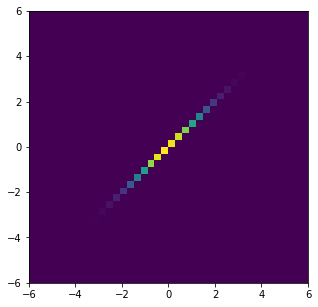

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

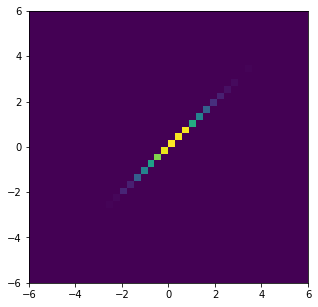

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

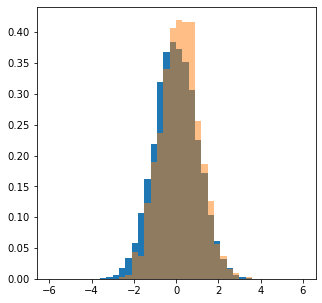

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.57660064]
 [-1.56505895]
 [ 1.89984006]
 ...
 [ 0.10881942]
 [-0.61619909]
 [-0.61231825]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.77660064]
 [-1.76505895]
 [ 1.69984006]
 ...
 [-0.09118058]
 [-0.81619909]
 [-0.81231825]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.47778278 0.16578397 0.09282298 ... 0.56085898 0.46663141 0.46774511]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.43201556 0.09161949 0.10533396 ... 0.6236684  0.41551888 0.41714308]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

In [35]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

### Estimate initial pdfs
Need pdf values for both train (MC) and true (fake data) at the location of each train event to comput the weight.  If that's too slow, could evaluate both in a grid and use the closest grid point for computing the weights.

To do it in the numpy way (without loops) will need N^2 arrays?  Or 2 x N arrays?

Did initial testing on laptop (work/ai/jupyter-notebooks).

To make things efficient, especially beyond one iteration, calculate a N x N array of booleans (for the MC), where it saves for each event pair whether the events are within the radius defining the density estimate.

Since the weights are applied to the MC, will need a Ndata x Nmc array of booleans for the data?

For the data, there are no evolving weights, so what's really needed is just a measure of the probability density at the location of the MC events.  Calculate it once and then use the same numbers in each iteration.


In [36]:
#global train_train_det_within_sphere
train_train_det_within_sphere = np.zeros( shape=(ngen_train ,ngen_train), dtype=bool )

#global train_train_gen_within_sphere
train_train_gen_within_sphere = np.zeros( shape=(ngen_train ,ngen_train), dtype=bool )

In [37]:
%%time

rd = simple_pdf.simple_pdf1a( train_both, true_det_pts, 
                             train_train_det_within_sphere, train_train_gen_within_sphere,
                             of_niter, radius, norm_radius2, True, True )




  ======== simple_pdf1a


  shape of theta0_S : (10000, 1)
  shape of theta0_G : (10000, 1)
  shape of theta_unknown_S : (1000, 1)

  iterations = 5

  scales : [0.5]
  radius = 1.00

  compute radii :  True
  ndim : 1





 Calculating distance between all pairs of MC events
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
  --- Done calculating 
 train_train_det_within_sphere 
[[ True False False ...  True  True False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [ True False False ...  True  True False]
 [ True False False ...  True  True False]
 [False False False ... False False  True]]


 Calculating pdf from data, detector features
             0 /        10000
          1000 /      

In [38]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

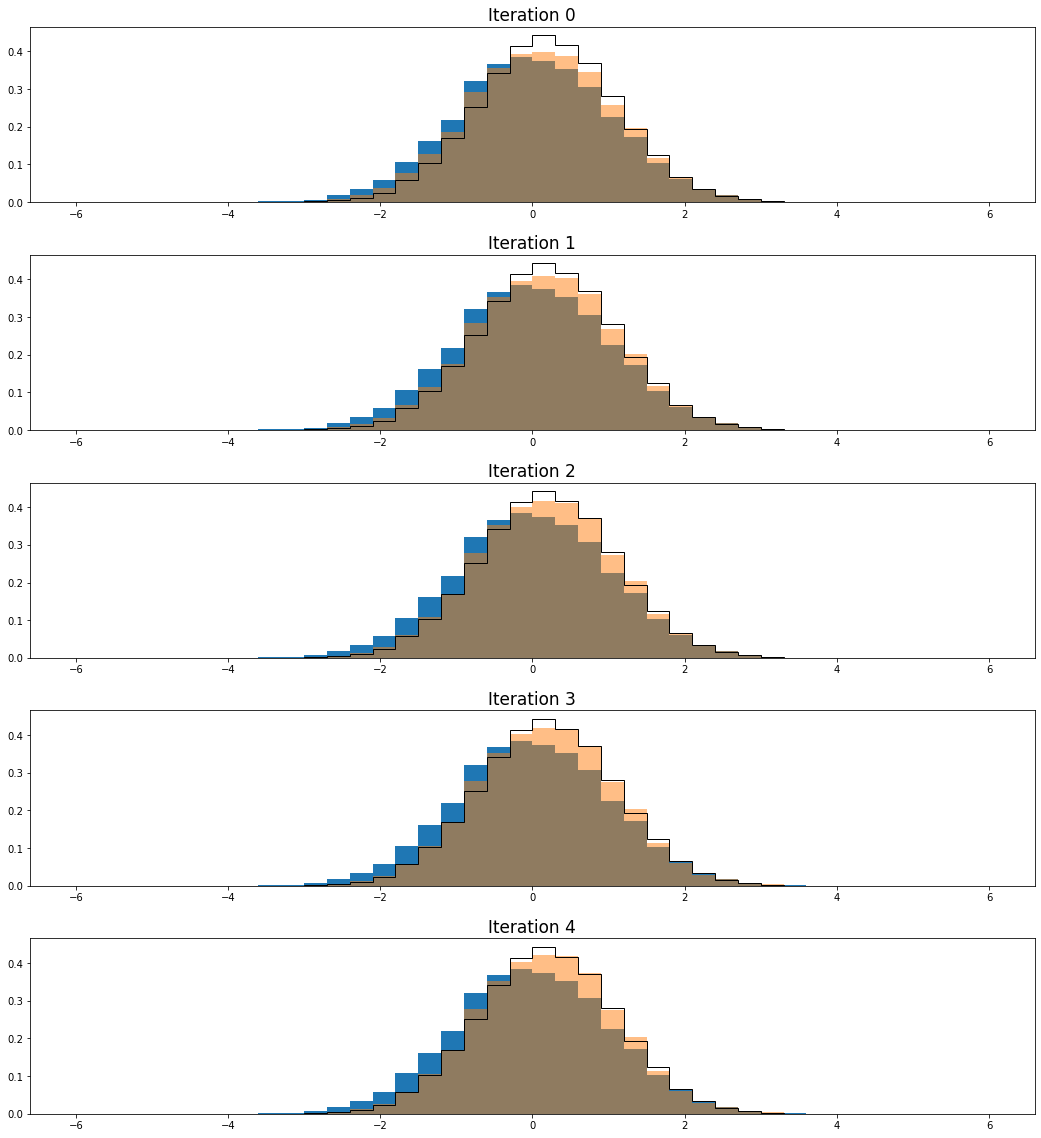

In [39]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [40]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

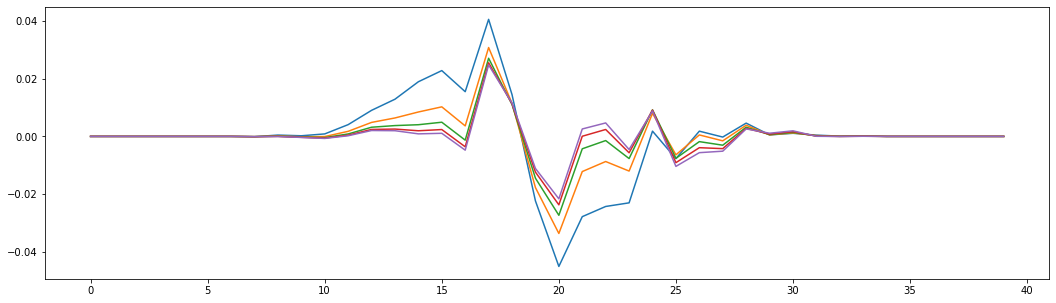

In [41]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

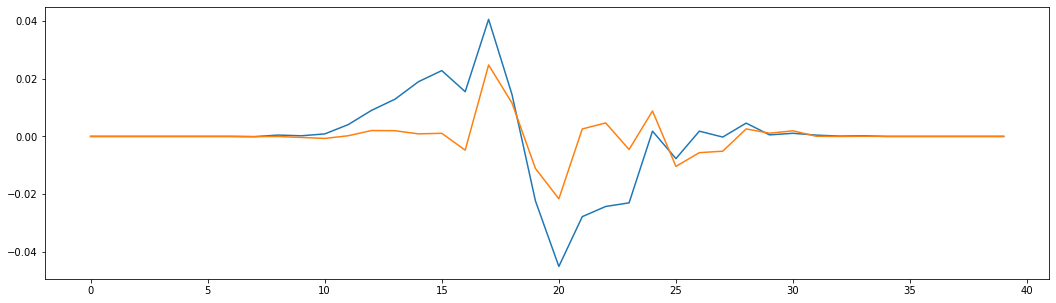

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

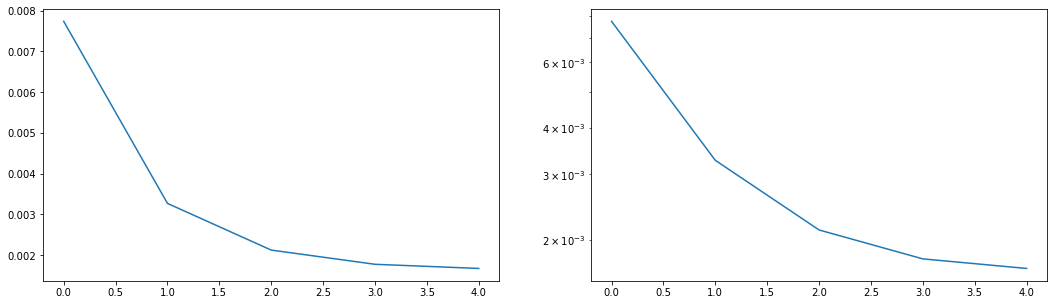

In [43]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

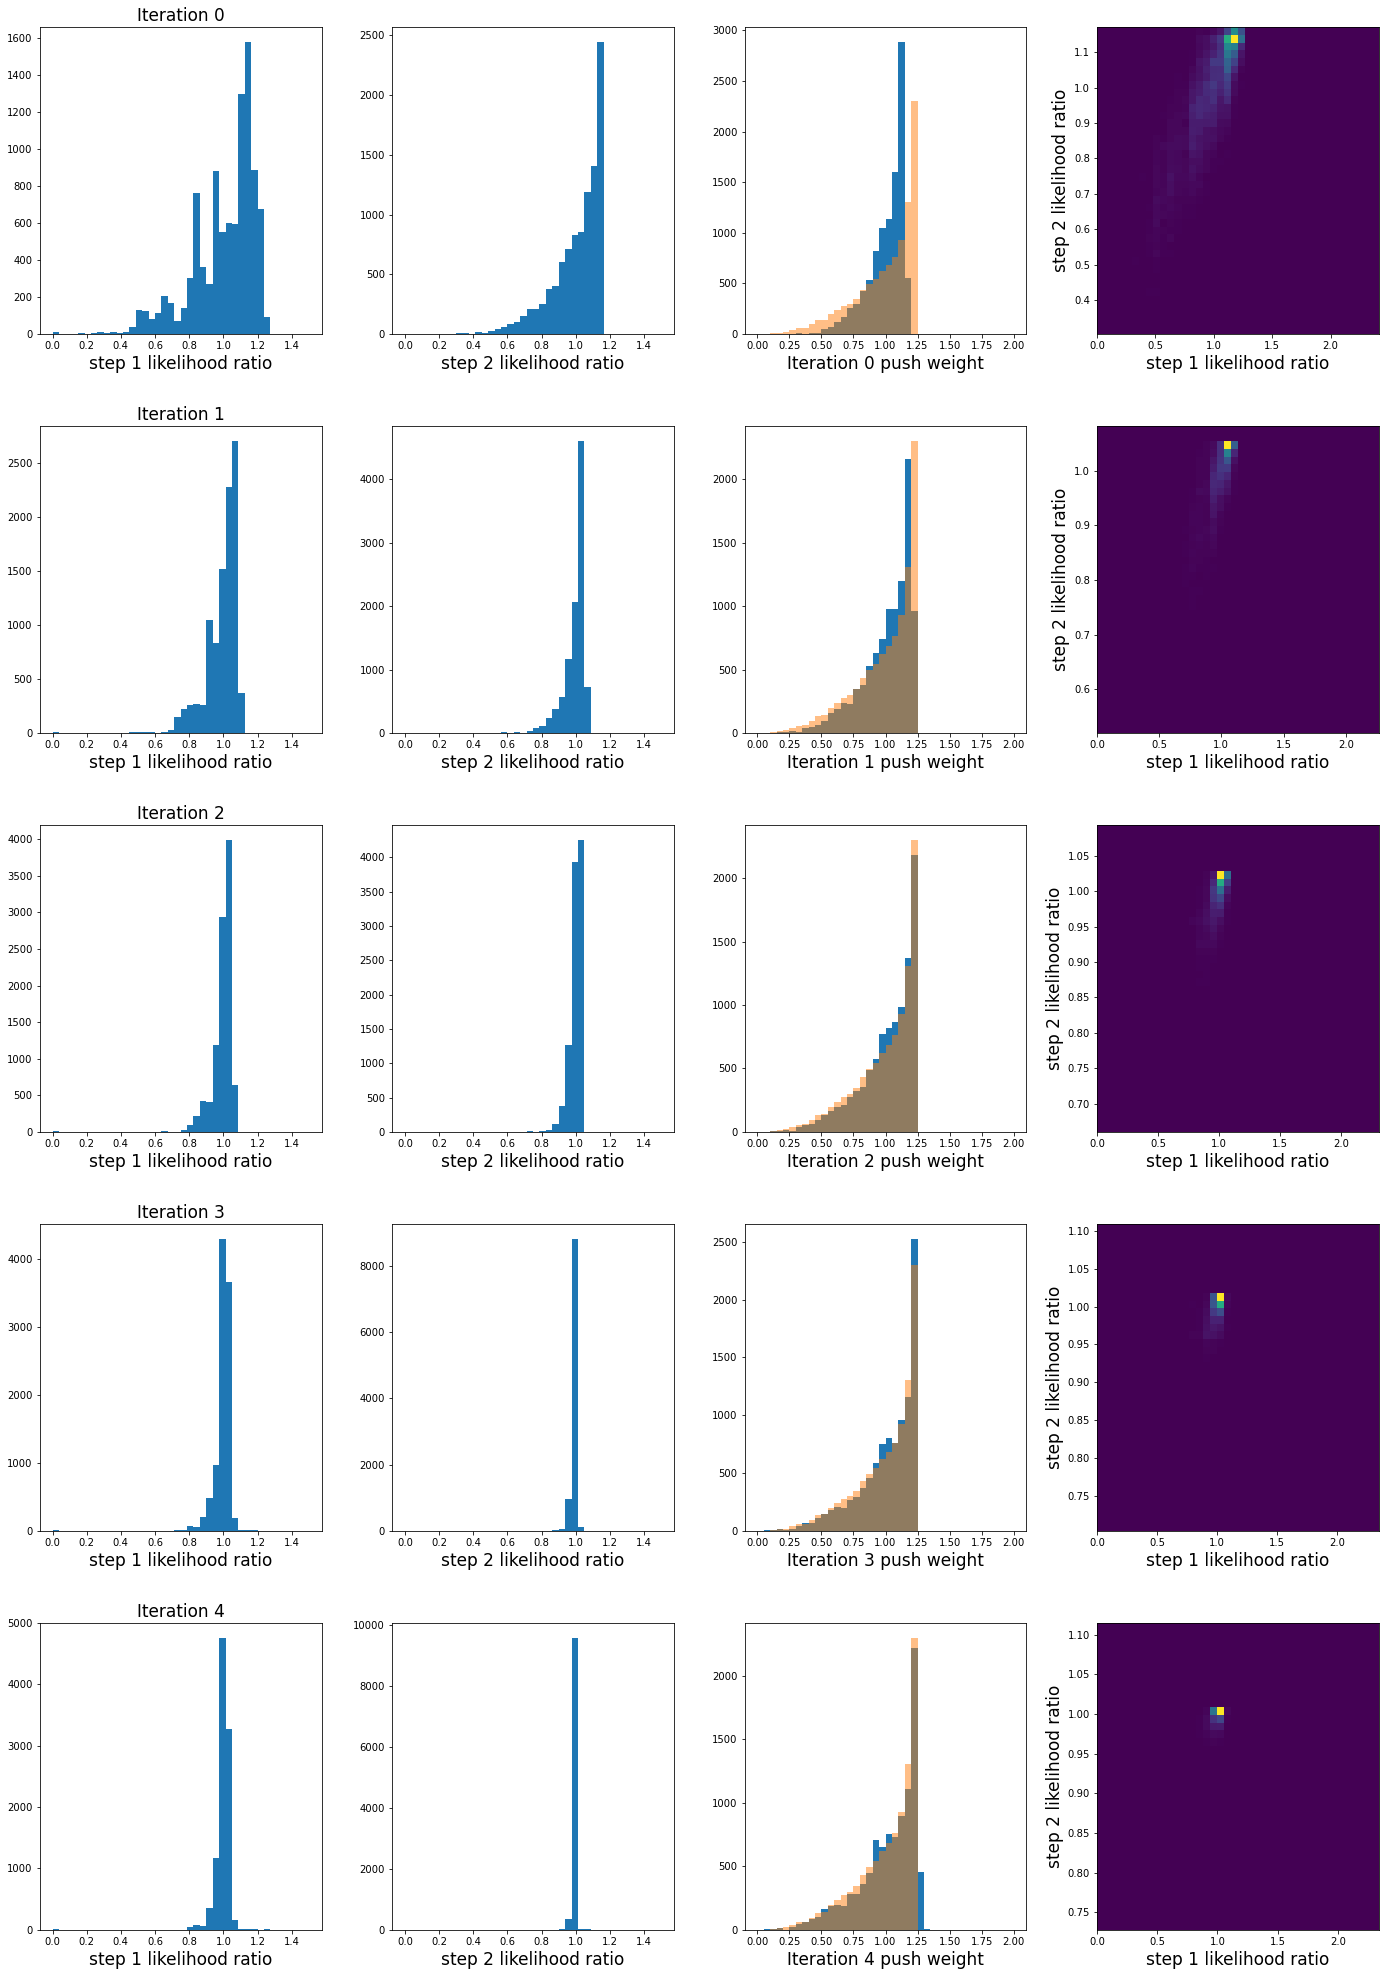

In [44]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

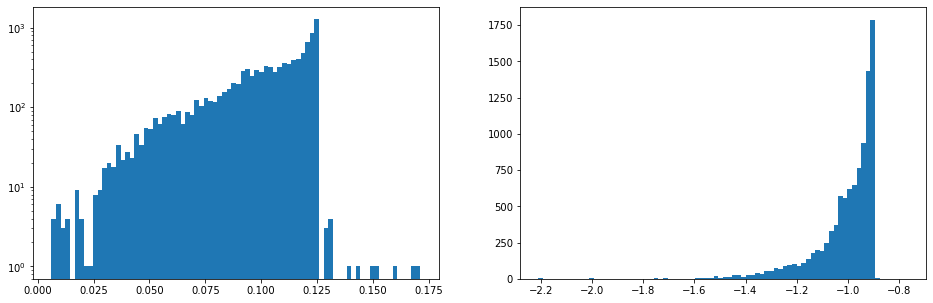

In [45]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

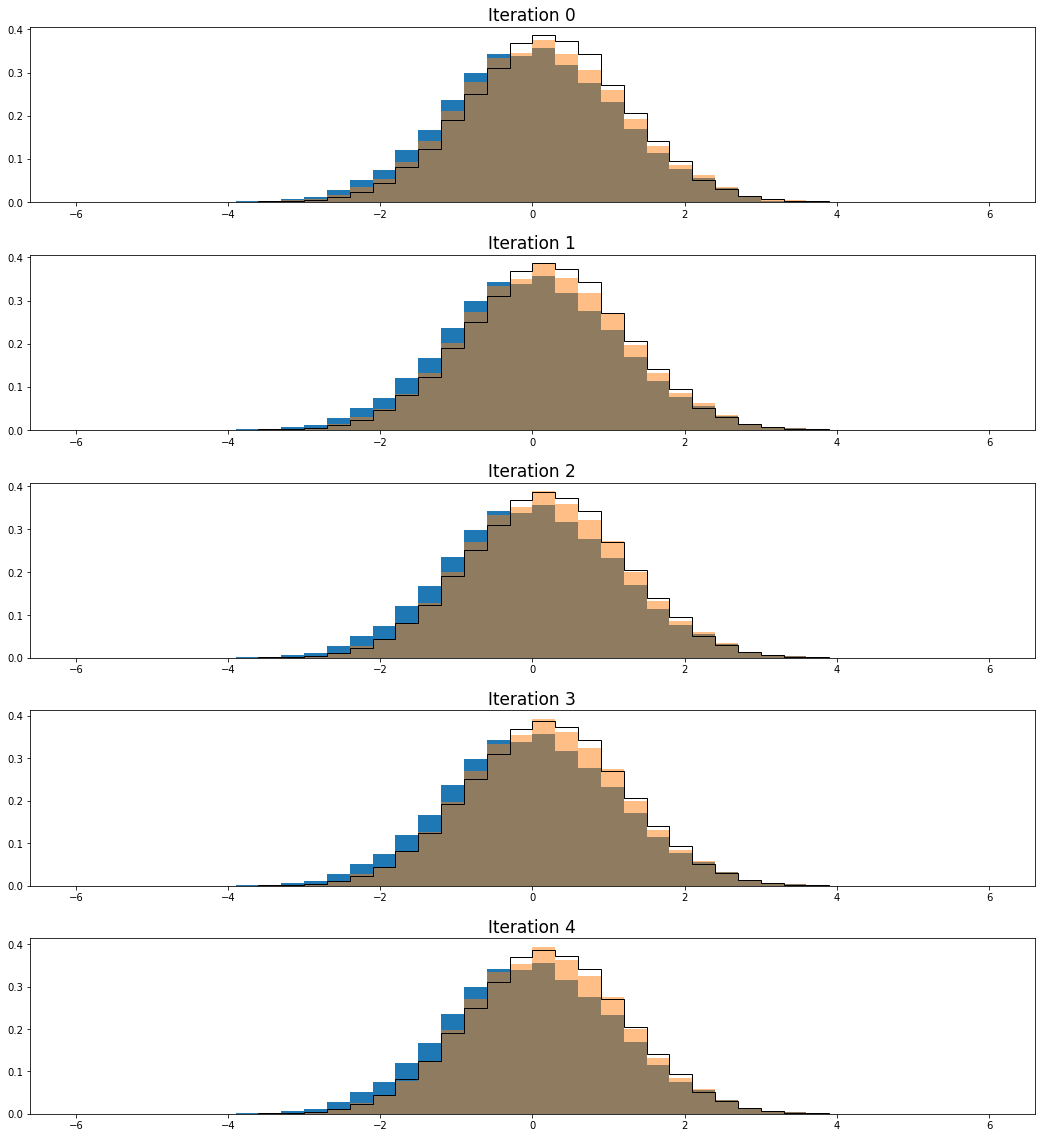

In [46]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [47]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

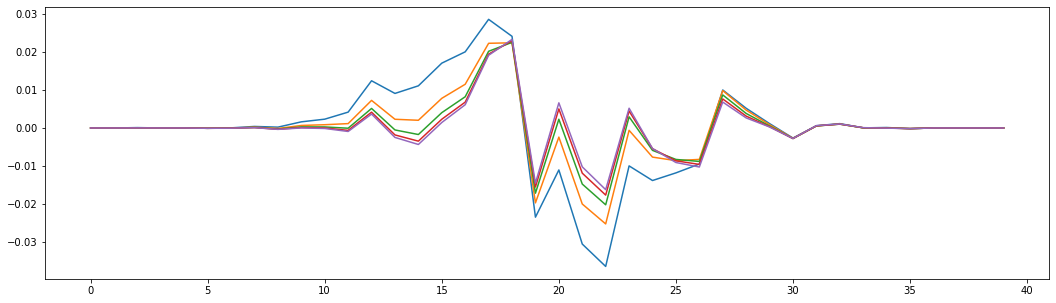

In [48]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

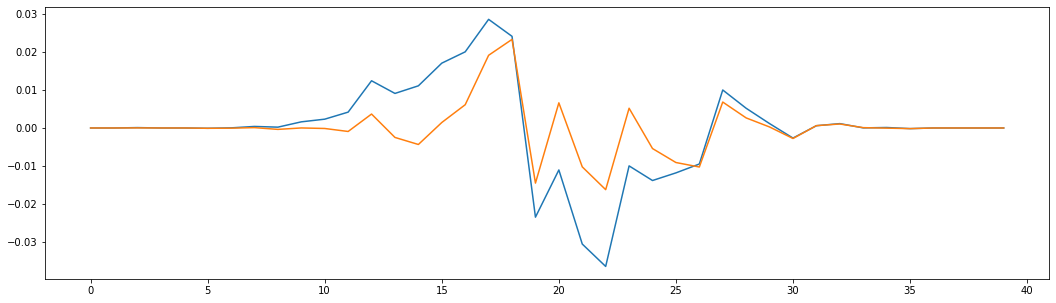

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

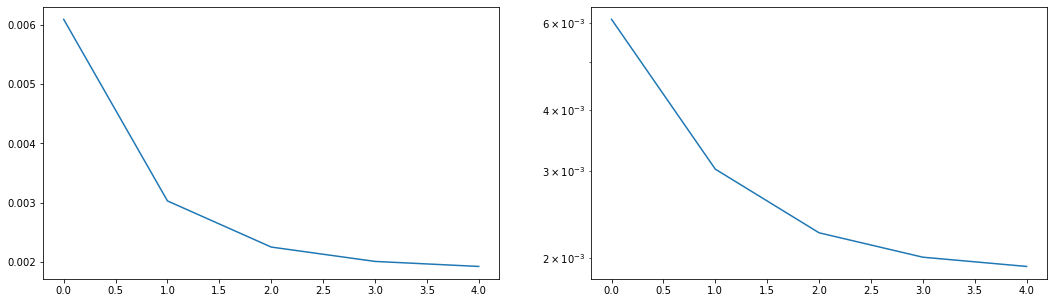

In [50]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [51]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.004  rms 0.188      step 2 mean  1.007  rms 0.143
  iter  1 : step 1 mean  0.993  rms 0.100      step 2 mean  0.996  rms 0.063
  iter  2 : step 1 mean  0.995  rms 0.072      step 2 mean  0.997  rms 0.033
  iter  3 : step 1 mean  0.997  rms 0.063      step 2 mean  0.998  rms 0.019
  iter  4 : step 1 mean  0.998  rms 0.061      step 2 mean  0.999  rms 0.013


<function matplotlib.pyplot.show(close=None, block=None)>

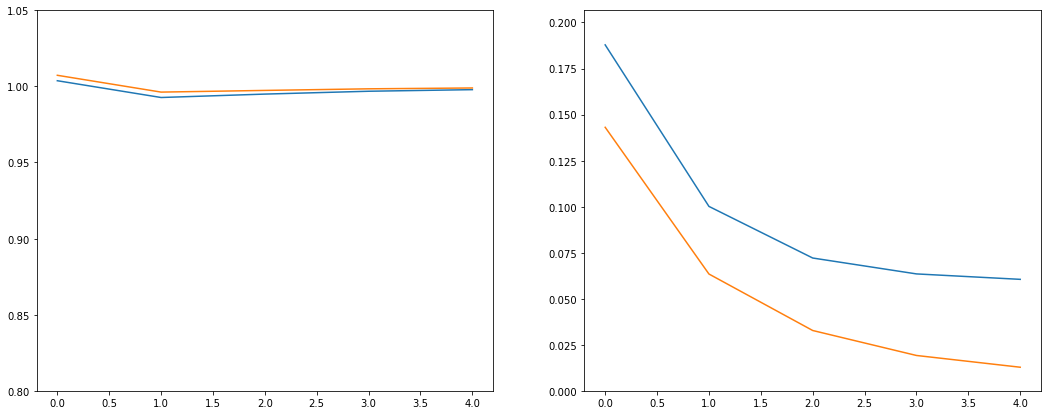

In [52]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

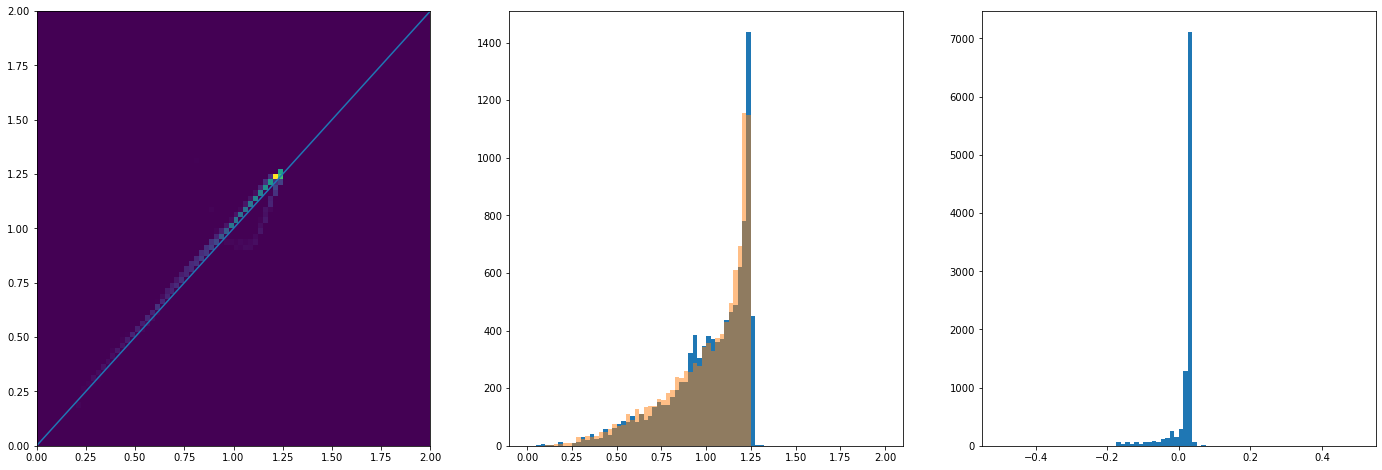

In [53]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [54]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.04034




In [55]:

verbose = False



import gc

In [56]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

    rd = simple_pdf.simple_pdf1a( train_both, boot_true_det_pts, 
                             train_train_det_within_sphere, train_train_gen_within_sphere,
                             of_niter, radius, norm_radius2, False, False )

    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95848574 0.7957729  1.03886807 ... 1.07290212 0.9515454  0.95216757]
 weights_push at the beginning
[0.94016779 0.7302051  1.00967597 ... 1.11280912 0.93005457 0.93100806]
 weights_push at the beginning
[0.92933496 0.7088214  0.97509474 ... 1.13740447 0.91748889 0.91865976]
 weights_push at the beginning
[0.92083741 0.70442546 0.94724658 ... 1.1535332  0.90791597 0.9092494 ]


 bootstrap 0 final push weights scaled:
[0.09132282 0.07071684 0.09266988 ... 0.11647315 0.08995659 0.09010319]

 Creating toy sample   1
             0 /        10000
          1000 /        10000
       

          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96190091 0.75925792 1.09561416 ... 1.06772267 0.95510368 0.95559996]
 weights_push at the beginning
[0.95144472 0.6784726  1.09391738 ... 1.1023137  0.94181408 0.94251484]
 weights_push at the beginning
[0.9494691  0.64656342 1.0747737  ... 1.12270854 0.93844897 0.93924806]
 weights_push at the beginning
[0.94945523 0.63336479 1.05691225 ... 1.13531078 0.93768746 0.93853732]


 bootstrap 9 final push weights scaled:
[0.09495834 0.06283564 0.10434355 ... 0.11433761 0.09373876 0.09382642]

 Creating toy sample  10
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1

 weights_push at the beginning
[0.89048994 0.68059757 1.1915675  ... 1.06189785 0.88080413 0.88165305]
 weights_push at the beginning
[0.84510016 0.58788588 1.20382375 ... 1.09100245 0.8316147  0.83286103]
 weights_push at the beginning
[0.8233008  0.55551853 1.17348453 ... 1.10915216 0.80780638 0.80930771]
 weights_push at the beginning
[0.81067281 0.54302329 1.13886546 ... 1.12142389 0.79386826 0.79556378]


 bootstrap 18 final push weights scaled:
[0.08022829 0.05377021 0.11089346 ... 0.11301952 0.07844936 0.07863513]

 Creating toy sample  19
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92090696 0.6479224  1.14861148 ... 1.1020835  0.90961271 0

 weights_push at the beginning
[0.90594382 0.65664108 1.15082593 ... 1.09408037 0.89613899 0.89678253]
 weights_push at the beginning
[0.89582646 0.631615   1.1272883  ... 1.11126127 0.88507856 0.88575649]
 weights_push at the beginning
[0.890564   0.62596385 1.10206802 ... 1.12159252 0.87952228 0.88018793]


 bootstrap 27 final push weights scaled:
[0.08868764 0.0628152  0.10811257 ... 0.11279903 0.08758377 0.08764705]

 Creating toy sample  28
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91407985 0.61642515 1.26888842 ... 1.07744024 0.90374577 0.90455425]
 weights_push at the beginning
[0.88613403 0.49809698 1.33565709 ... 1.114587   0.87157645 0

 weights_push at the beginning
[0.94250132 0.51261451 1.23374874 ... 1.11772303 0.93100134 0.93160241]
 weights_push at the beginning
[0.95059698 0.48621233 1.22840761 ... 1.12702386 0.93876949 0.93932427]


 bootstrap 36 final push weights scaled:
[0.09589929 0.04700631 0.12243562 ... 0.11318497 0.09471985 0.09476843]

 Creating toy sample  37
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9344093  0.69079141 1.0386693  ... 1.10160448 0.92465101 0.92550797]
 weights_push at the beginning
[0.90566153 0.59502623 0.97765918 ... 1.15341321 0.89187257 0.89315998]
 weights_push at the beginning
[0.89158376 0.56172233 0.91078971 ... 1.18442178 0.87583864 0

 weights_push at the beginning
[0.93149882 0.57655071 1.00354016 ... 1.15774069 0.91539271 0.9171086 ]


 bootstrap 45 final push weights scaled:
[0.09292339 0.05632333 0.09823162 ... 0.11698374 0.0911889  0.09138084]

 Creating toy sample  46
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99396913 0.74846397 0.9213435  ... 1.11805797 0.98511692 0.98587758]
 weights_push at the beginning
[0.9914612  0.65266064 0.83464395 ... 1.18716747 0.97788244 0.97907918]
 weights_push at the beginning
[0.98879898 0.60976145 0.77010096 ... 1.23127204 0.97236532 0.97384674]
 weights_push at the beginning
[0.9851277  0.58957151 0.72452859 ... 1.26081005 0.96683457 0



 bootstrap 54 final push weights scaled:
[0.0960413  0.05728374 0.09519079 ... 0.1122774  0.09502981 0.09502591]

 Creating toy sample  55
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9047581  0.66432527 1.23906828 ... 1.05582533 0.89591568 0.89664871]
 weights_push at the beginning
[0.87193008 0.56122098 1.28122004 ... 1.08164416 0.85988139 0.8609299 ]
 weights_push at the beginning
[0.86084329 0.52006976 1.27030669 ... 1.09802573 0.84731158 0.84854757]
 weights_push at the beginning
[0.85699876 0.50029988 1.24942057 ... 1.10892559 0.84267094 0.8440411 ]


 bootstrap 55 final push weights scaled:
[0.08557088 0.04892205 0.12296946 ... 0.11163546 

          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89273749 0.73616262 1.30387313 ... 1.02707002 0.88582817 0.88636835]
 weights_push at the beginning
[0.85396187 0.66690093 1.40172884 ... 1.03695358 0.84490141 0.84563356]
 weights_push at the beginning
[0.83900067 0.64944054 1.43101103 ... 1.04405702 0.82908929 0.82991712]
 weights_push at the beginning
[0.83221549 0.64790477 1.4404932  ... 1.04975238 0.82188511 0.82277517]


 bootstrap 64 final push weights scaled:
[0.08285059 0.06513562 0.14452572 ... 0.10545509 0.08179183 0.08188567]

 Creating toy sample  65
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[

 weights_push at the beginning
[0.93625177 0.70778693 1.07897559 ... 1.08776462 0.92723281 0.92804957]
 weights_push at the beginning
[0.90975801 0.61425292 1.04669064 ... 1.13463041 0.89698679 0.89821754]
 weights_push at the beginning
[0.89649742 0.57919002 1.00034243 ... 1.16382475 0.88188637 0.88338294]
 weights_push at the beginning
[0.88789034 0.56624338 0.96046961 ... 1.18309335 0.87230067 0.87399288]


 bootstrap 73 final push weights scaled:
[0.08811937 0.05628764 0.09294985 ... 0.11964255 0.0865063  0.08669124]

 Creating toy sample  74
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95488842 0.71261469 1.10399457 ... 1.08634843 0.94601266 0

 weights_push at the beginning
[0.87531874 0.67397407 1.25154817 ... 1.05308651 0.86677076 0.8674536 ]
 weights_push at the beginning
[0.86238236 0.65755007 1.24472505 ... 1.05878351 0.85330254 0.85405428]
 weights_push at the beginning
[0.85670418 0.65808939 1.22768895 ... 1.06106607 0.8475692  0.84835655]


 bootstrap 82 final push weights scaled:
[0.08537665 0.06642434 0.12107856 ... 0.10616418 0.08447447 0.0845557 ]

 Creating toy sample  83
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94332287 0.69591891 1.2083552  ... 1.0582424  0.93597418 0.93647616]
 weights_push at the beginning
[0.9302343  0.59523424 1.25873909 ... 1.08355479 0.92022643 0

 weights_push at the beginning
[0.9791356  0.55199935 1.01606584 ... 1.17489534 0.96430229 0.96549197]
 weights_push at the beginning
[0.9837269  0.52570982 0.99326145 ... 1.19510625 0.96746103 0.96878279]


 bootstrap 91 final push weights scaled:
[0.09875891 0.0510357  0.0977456  ... 0.12085522 0.09703648 0.09717816]

 Creating toy sample  92
             0 /        10000
          1000 /        10000
          2000 /        10000
          3000 /        10000
          4000 /        10000
          5000 /        10000
          6000 /        10000
          7000 /        10000
          8000 /        10000
          9000 /        10000
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95809175 0.71046619 1.01926174 ... 1.0892967  0.95011741 0.95068857]
 weights_push at the beginning
[0.94408978 0.6110056  0.95743882 ... 1.13249575 0.93297309 0.93375609]
 weights_push at the beginning
[0.94018107 0.56899211 0.89348561 ... 1.1558269  0.92774392 0

In [57]:
print('\n\n Done.\n\n')



 Done.


